<a href="https://colab.research.google.com/github/NirTaube/RHOpen/blob/main/Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#import data
test_data = pd.read_csv("sample_data/Data/test.csv")
train_data = pd.read_csv("sample_data/Data/train.csv")

In [3]:
# Features
features = train_data.drop(['Id', 'SalePrice'], axis=1)

# Define The Target variable
target = train_data['SalePrice']

train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=0.2, random_state=100)


In [4]:
# Preprocess categorical columns with one-hot encoding
categorical_columns = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
    'SaleCondition'
]

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')


In [5]:

# Fit the encoder using the categorical features from the training dataset
encoder.fit(train_features[categorical_columns])

# Apply the encoder to the train and validation datasets
train_features_encoded = train_features.join(pd.DataFrame(encoder.transform(train_features[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=train_features.index))
val_features_encoded = val_features.join(pd.DataFrame(encoder.transform(val_features[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns), index=val_features.index))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:

# Remove original categorical features
train_features_encoded = train_features_encoded.drop(columns=categorical_columns)
val_features_encoded = val_features_encoded.drop(columns=categorical_columns)

# Convert the encoded features and target to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features_encoded.values, train_target.values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features_encoded.values, val_target.values))


In [7]:

# Add batch operation to the datasets
batch_size = 100
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Define the model
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

# Train the model
model.fit(train_dataset, validation_data=val_dataset)


Use /tmp/tmpho_iy1td as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.700201. Found 1168 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(292, shape=(), dtype=int32)
Validation dataset read in 0:00:13.468035. Found 292 examples.
Training model...
Model trained in 0:00:28.202037
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [8]:
# Print the shapes of input data and target values in val_dataset
for x, y in val_dataset.take(5):
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)

# Make predictions
predictions = model.predict(val_dataset)

# Get the actual target values from the validation dataset
actual_values = list(val_target.values)


Input shape: (100, 301)
Target shape: (100,)
Input shape: (100, 301)
Target shape: (100,)
Input shape: (92, 301)
Target shape: (92,)
3/3 [==============================] - 1s 10ms/step


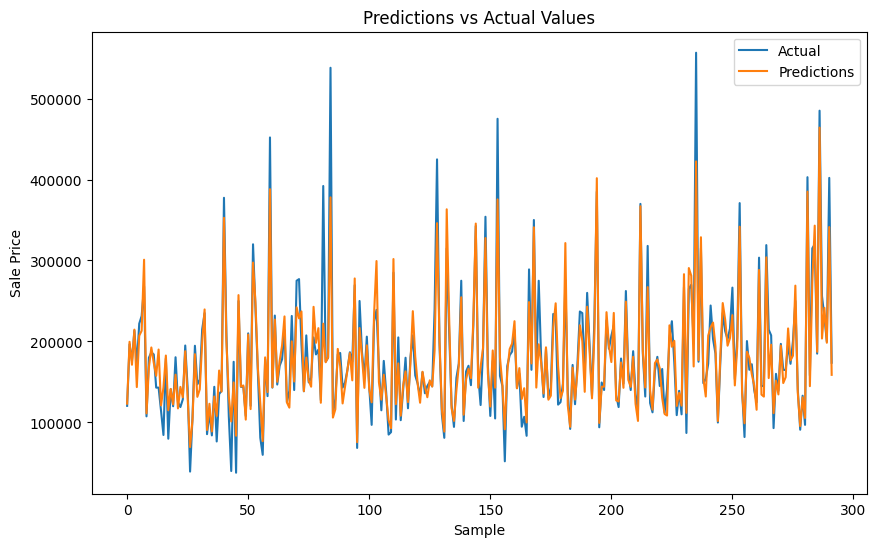

In [9]:
# Plot the predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Sale Price')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

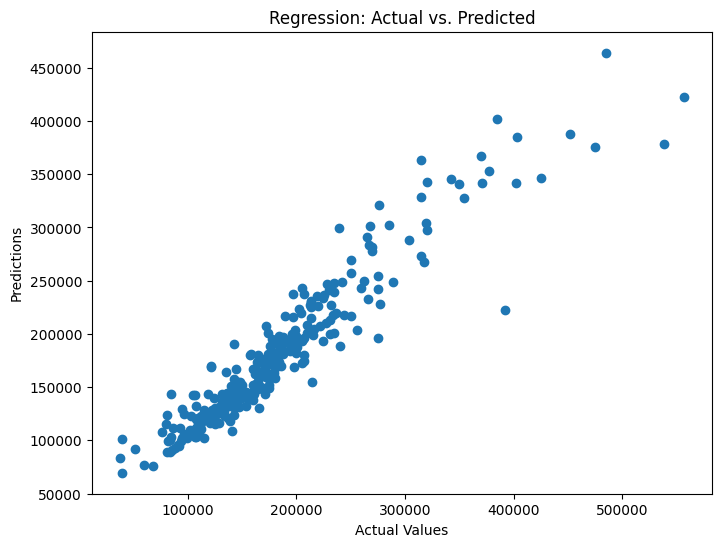

Mean Squared Error (MSE): 722083535.6865124
Mean Absolute Error (MAE): 17063.372939854453
R-squared (R2) Score: 0.8876849575352795


In [10]:

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Regression: Actual vs. Predicted')
plt.show()


# Regression evaluation metrics
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 6383438149.0262985
Mean Absolute Error (MAE): 66474.96198095035
R-squared (R2) Score: 0.0071008528159168804


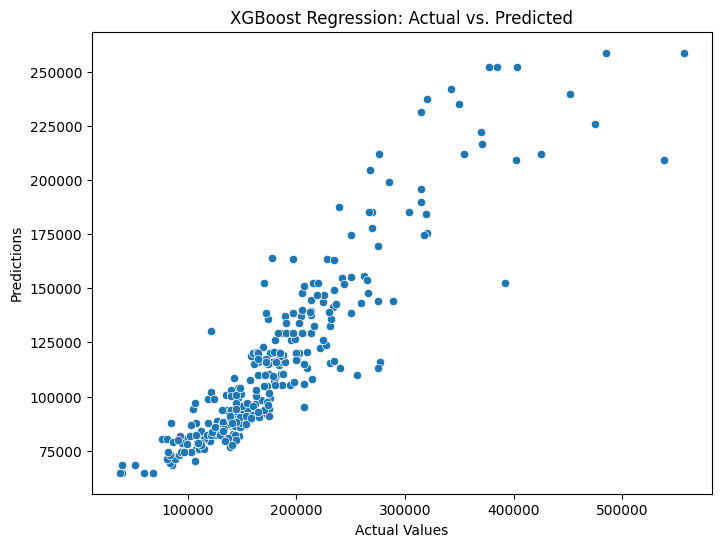

In [11]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_features_encoded, label=train_target)
dval = xgb.DMatrix(val_features_encoded, label=val_target)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the validation set
predictions = model.predict(dval)

# Evaluate the model
mse = mean_squared_error(val_target, predictions)
mae = mean_absolute_error(val_target, predictions)
r2 = r2_score(val_target, predictions)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_target, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('XGBoost Regression: Actual vs. Predicted')
plt.show()


In [12]:
from sklearn.impute import SimpleImputer
# Check for NaN values
nan_columns = np.isnan(train_features_encoded).any()
nan_features = train_features_encoded.columns[nan_columns]

# Apply mean imputation to handle NaN values
imputer = SimpleImputer(strategy='mean')
train_features_encoded[nan_features] = imputer.fit_transform(train_features_encoded[nan_features])
val_features_encoded[nan_features] = imputer.transform(val_features_encoded[nan_features])

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(train_features_encoded.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(train_features_encoded, train_target, validation_data=(val_features_encoded, val_target), epochs=100, batch_size=100)

# Make predictions
predictions = model.predict(val_features_encoded)

# Evaluate the model
mse = mean_squared_error(val_target, predictions)
mae = mean_absolute_error(val_target, predictions)
r2 = r2_score(val_target, predictions)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Epoch 1/100
37/37 [==============================] - 2s 12ms/step - loss: 37497995264.0000 - val_loss: 36149362688.0000
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 31616888832.0000 - val_loss: 25722519552.0000
Epoch 3/100
37/37 [==============================] - 0s 5ms/step - loss: 17869795328.0000 - val_loss: 10523723776.0000
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 8840197120.0000 - val_loss: 7167576064.0000
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 7032067072.0000 - val_loss: 6326197248.0000
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 6341794304.0000 - val_loss: 5754918400.0000
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 5725027328.0000 - val_loss: 5290042880.0000
Epoch 8/100
37/37 [==============================] - 0s 3ms/step - loss: 5348743680.0000 - val_loss: 4734325760.0000
Epoch 9/100
37/37 [==============================] - 0s 3

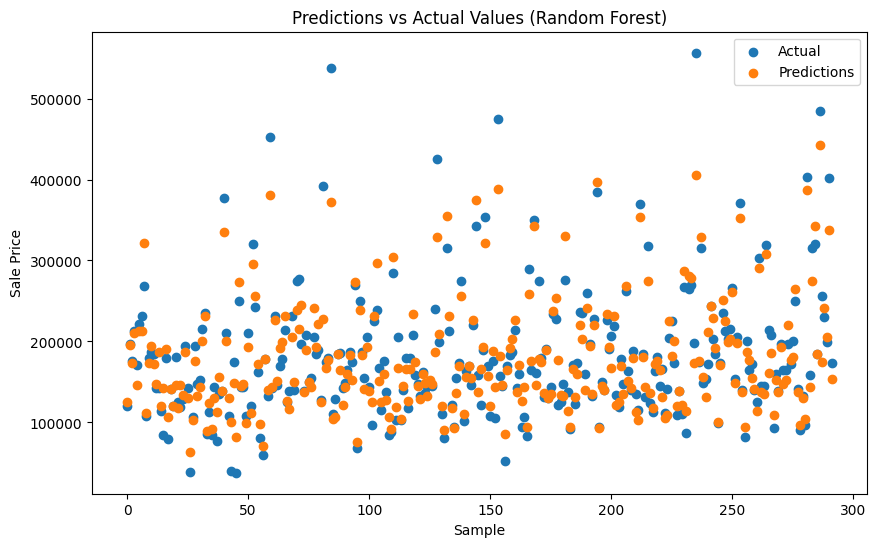

Mean Squared Error (MSE): 784092764.6080997
Mean Absolute Error (MAE): 17607.115856164382
R-squared (R2) Score: 0.8780398557771967


In [15]:
from sklearn.ensemble import RandomForestRegressor


# Train the Random Forest model
model = RandomForestRegressor()
model.fit(train_features_encoded, train_target)

# Make predictions on the validation set
predictions = model.predict(val_features_encoded)

# Calculate the eval metrics
mse = mean_squared_error(val_target, predictions)
mae = mean_absolute_error(val_target, predictions)
r2 = r2_score(val_target, predictions)

# Plot the predictions versus the actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(val_target)), val_target, label='Actual')
plt.scatter(range(len(predictions)), predictions, label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Sale Price')
plt.title('Predictions vs Actual Values (Random Forest)')
plt.legend()
plt.show()

# Print eval metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)
